# Import the necessary packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import MDAnalysis as mda
import nglview as nv
import prolif as plf
import Bio
from pymol import cmd
import py3Dmol
import sys, os
from prolif.plotting.network import LigNetwork
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display, Image
from io import BytesIO
from openbabel import pybel
from pdbfixer import PDBFixer
import openmm
from simtk.openmm.app import PDBFile
from MDAnalysis import Universe

/home/veronika/miniconda3/envs/binding_env/lib/python3.10/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


# Functions

### Downloading structures for PDB database

With Biopython:

In [177]:
import os
import subprocess

def load_pdb_structure(pdb_id, file_format="pdb"):
    """
    Load a PDB structure by its ID from the PDB database.

    Parameters:
    - pdb_id: str, the four-letter PDB ID.
    - file_format: str, the format of the downloaded file (default is "pdb").

    Returns:
    - The path to the downloaded PDB file.
    """
    # Construct the URL for downloading the PDB file
    if file_format == "pdb":
        url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    elif file_format == "mmCif":
        url = f"https://files.rcsb.org/download/{pdb_id}.cif"
    else:
        raise ValueError("Unsupported file format. Only 'pdb' and 'mmCif' are supported.")
    
    # Construct the filename based on the PDB ID and file format
    if file_format == "pdb":
        filename = f"{pdb_id}.pdb"
    elif file_format == "mmCif":
        filename = f"{pdb_id}.cif"
    
    # Download the file using wget
    subprocess.run(['wget', url, '-O', filename])
    
    # Return the path to the downloaded file
    return os.path.abspath(filename)

or with Pymol:

In [5]:
from pymol import cmd
def loading_structure(pdb_id, file_format='pdb'):
    """ 
    Loads a protein structure from the Protein Data Bank (PDB) and separates the protein from ligands.
    
    Parameters:
    - pdb_id (str): The four-letter PDB ID of the structure to fetch.
    - file_format (str): The format of the downloaded file (default is "pdb").
    
    Returns:
    - Saves the protein structure in .pdb format and ligand(s) in .mol2 format.
    """
    try:
        # Fetch the structure from PDB
        cmd.fetch(code=pdb_id, type=file_format)
        
        # Select protein chains
        cmd.select(name='Prot', selection='polymer.protein')
        
        # Select organic ligands
        cmd.select(name='Lig', selection='organic')
        
        # Save protein structure to a PDB file
        cmd.save(filename=f'{pdb_id}_clean.pdb', format='pdb', selection='Prot')
        
        # Save ligand structure to a MOL2 file
        cmd.save(filename=f'{pdb_id}_lig.mol2', format='mol2', selection='Lig')
        
        # Clear workspace to free memory
        cmd.delete('all')
        
        print(f"Structures saved: {pdb_id}_clean.pdb (protein), {pdb_id}_lig.mol2 (ligand)")
    
    except Exception as e:
        print(f"An error occurred: {e}")

### Uploading structure from current directory

With Biopython

In [121]:
def upload_structure(pdb_id):
    parser = PDBParser()
    structure = parser.get_structure("Structure", f"{pdb_id}.pdb")
    return structure

With Pymol

In [7]:
from pymol import cmd

def loading_structure_from_dir(structure_filename):
    """ 
    Loads a protein structure from a manually downloaded file and separates the protein from ligands.
    
    Parameters:
    - pdb_id (str): The four-letter PDB ID of the structure (used for naming output files).
    - file_format (str): The format of the local file (default is "pdb").
    
    Returns:
    - Saves the protein structure in .pdb format and ligand(s) in .mol2 format.
    """
    try:
        # Load the structure from local file (assuming filename is pdb_id.format)
        cmd.load(filename=structure_filename)
        
        # Select protein chains
        cmd.select(name='Prot', selection='polymer.protein')
        
        # Select organic ligands
        cmd.select(name='Lig', selection='organic')
        
        # Save protein structure to a PDB file
        cmd.save(filename=f'{pdb_id}_clean.pdb', format='pdb', selection='Prot')
        
        # Save ligand structure to a MOL2 file
        cmd.save(filename=f'{pdb_id}_lig.mol2', format='mol2', selection='Lig')
        
        # Clear workspace to free memory
        cmd.delete('all')
        
        print(f"Structures saved: {pdb_id}_clean.pdb (protein), {pdb_id}_lig.mol2 (ligand)")
    
    except Exception as e:
        print(f"An error occurred: {e}")

### Visualizing

With MDanalysis:

In [122]:
def parse_het_records(pdb_id):
        """Parse HET records from PDB file to identify ligands."""
        ligands = set()
        with open(f"{pdb_id}.pdb", 'r') as f:
            for line in f:
                if line.startswith('HET '):  # Note the space after HET
                    resname = line[7:10].strip()
                    ligands.add(resname)
                elif line.startswith('HETNAM'):
                    # Optional: Could store the full ligand names
                    pass
        ligand_resname = sorted(list(ligands))
        return ligand_resname

In [41]:
def mda_visual(pdb_id, ligand_resname):
    # Load PDB file
    u = mda.Universe(f"{pdb_id}.pdb")
    
    # Select protein and ligands
    protein = u.select_atoms("protein")
    ligands = [(name, u.select_atoms(f"resname {name}")) for name in ligand_resname]
    
    # Create visualization base
    view = nv.show_mdanalysis(protein)
    view.clear_representations()
    view.add_representation("surface", colorScheme="hydrophobicity")
    
    # Track ligand findings
    any_ligand_found = False
    
    for lig_name, lig in ligands:
        if lig.n_atoms > 0:
            # Add ligand to visualization
            lig_view = view.add_component(lig)
            lig_view.center()
            any_ligand_found = True
        else:
            print(f"Warning: No ligand {lig_name} found in {pdb_id}")
    
    if not any_ligand_found:
        print(f"No valid ligands found in {pdb_id}. Showing protein only.")
        
    return view

With Pymol3D:

In [10]:
def pymol3d_visual(pdb_id):
    view = py3Dmol.view()
    view.removeAllModels()
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    
    view.addModel(open(f'{pdb_id}_clean.pdb','r').read(),format='pdb')
    Prot=view.getModel()
    Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
    view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})
    
    
    view.addModel(open(f'{pdb_id}_lig.mol2','r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
    
    view.zoomTo()
    view.show()
    return view

Checking ligand structure if any:

In [139]:
def visualize_multiple_ligands_from_mol2(pdb_id):
    """
    Extract and visualize multiple ligands, handling identical ligands, from a .mol2 file.
    Allows specifying image size.
    """
    view = py3Dmol.view()
    view.removeAllModels()
    view.setViewStyle({'style':'outline','color':'black','width':0.1})
    
    # view.addModel(open(f'{pdb_id}_clean.pdb','r').read(),format='pdb')
    # Prot=view.getModel()
   # Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
    # view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})
    
    
    view.addModel(open(f'{pdb_id}_lig.mol2','r').read(),format='mol2')
    ref_m = view.getModel()
    ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})
    
    view.zoomTo()
    #view.show()
    return view

Visualizing binding site:

In [267]:
def visualize_binding_site(pdb_id, ligand_resname):
    # Load PDB file
    u = mda.Universe(f"{pdb_id}.pdb")
    
    # Select protein and ligands
    protein = u.select_atoms("protein")
    ligands = [(name, u.select_atoms(f"resname {name}")) for name in ligand_resname]
    
    # Create visualization base
    view = nv.show_mdanalysis(u)
    view.clear_representations()
    view.add_representation("cartoon", colorScheme="electrostatic", opacity=0.5)  # Shows charge
    view.add_representation("cartoon", colorScheme="sstruc", opacity=0.5)  # Secondary structure
    #view.add_representation("surface", color="lightgray", opacity=0.5)  # Uniform color
    
    view.camera = "orthographic"
    
    # Track ligand findings
    any_ligand_found = False
    
    for lig_name, lig in ligands:
        if lig.n_atoms > 0:
            # Add ligand to visualization
            lig_view = view.add_component(lig)
            lig_view.center()
            any_ligand_found = True
            # Use ProLIF to analyze interactions with NoImplicit=False
            try:
                protein_mol = plf.Molecule.from_mda(protein, NoImplicit=False)
                ligand_mol = plf.Molecule.from_mda(lig, NoImplicit=False)
                fp = plf.Fingerprint()
                interactions = fp.generate(protein_mol, ligand_mol)
            
                # Display interactions
                print("Interactions:")
                for interaction in interactions:
                    print(interaction)
            except Exception as e:
                print(f"Could not analyze interactions: {e}")
        else:
            print(f"Warning: No ligand {lig_name} found in {pdb_id}")
    
    if not any_ligand_found:
        print(f"No valid ligands found in {pdb_id}. Showing protein only.")
    
    return view

Visualizing in interaction:

In [198]:
from Bio import PDB
import numpy as np
import nglview as nv

def visualize_protein_ligand_interactions(pdb_path, ligand_name):
    # Load the PDB file
    parser = PDB.PDBParser()
    structure = parser.get_structure('protein', pdb_path)
    
    # Find interacting residues and hydrogen bonds
    ligand_atoms = []
    for atom in structure.get_atoms():
        if atom.get_parent().get_resname() == ligand_name:
            ligand_atoms.append(atom)
    
    interacting_residues = []
    hydrogen_bonds = []  # Will store tuples of (ligand_atom, protein_atom)
    
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.get_resname() != ligand_name:
                    for atom1 in ligand_atoms:
                        for atom2 in residue:
                            distance = np.linalg.norm(np.array(atom1.get_coord()) - np.array(atom2.get_coord()))
                            if distance <= 5:
                                interacting_residues.append(residue)
                                
                                # Simple hydrogen bond detection (distance-based)
                                # You might want to refine this with angle criteria
                                if distance <= 3.5:  # Typical H-bond distance cutoff
                                    # Check if one atom is donor (N,O) and other is acceptor (O,N)
                                    donor_types = ['N', 'O']
                                    acceptor_types = ['O', 'N']
                                    if (atom1.element in donor_types and atom2.element in acceptor_types) or \
                                       (atom1.element in acceptor_types and atom2.element in donor_types):
                                        hydrogen_bonds.append((atom1, atom2))
                                break
                        else:
                            continue
                        break
    
    # Visualize the structure using nglview
    view = nv.show_file(pdb_path)
    
    # Highlight the ligand and interacting residues
    view.add_representation('ball+stick', selection=f'resn {ligand_name}', color='red')
    for residue in interacting_residues:
        view.add_representation('ball+stick', selection=f'resi {residue.get_id()[1]}', color='blue')
    
    # Add dashed lines for hydrogen bonds
    for atom1, atom2 in hydrogen_bonds:
        # Get atom identifiers
        atom1_id = f"{atom1.get_parent().get_id()[1]}:{atom1.get_parent().get_resname()}:{atom1.get_name()}"
        atom2_id = f"{atom2.get_parent().get_id()[1]}:{atom2.get_parent().get_resname()}:{atom2.get_name()}"
        
        # Add dashed line representation
        view.add_distance(
            atom_pair=[f"{atom1_id}", f"{atom2_id}"],
            color='white',
            dashed=True,
            dashLength=0.2,
            labelVisible=False
        )
    
    # Display the view
    return view

# Examples

### Write your PDB ID and parse the structure

In [13]:
os.listdir()

['9fbd.pdb',
 '3vsk_clean.pdb',
 '9fbd_lig_H.mol2',
 '9fbd_lig_0_H.mol2',
 '9fbd_clean_H.pdb',
 'temp.png',
 'pdb3vsk.ent',
 'auto_binding_vis.ipynb',
 '9fbd_lig_molecule_1_with_H.mol2',
 '9fbd_lig.mol2',
 'obsolete',
 '3vsk_lig.mol2',
 '3vsk.pdb',
 '.ipynb_checkpoints',
 '9fbd_clean_processed.pdb',
 'pdb4hhb.ent',
 '9fbd_clean.pdb',
 'pdb9fbd.ent']

In [14]:
pdb_id = "3vsk"
pdb_filename = load_pdb_structure(pdb_id)
structure = parse_pdb_file(pdb_filename)

print(f"Parsed structure: {pdb_id}")

Structure exists: './pdb3vsk.ent' 
Parsed structure: 3vsk


or

In [15]:
pdb_id = "3vsk"
loading_structure(pdb_id)

Structures saved: 3vsk_clean.pdb (protein), 3vsk_lig.mol2 (ligand)


### Loading PDB to MDAnalysis

In [16]:
ligands = parse_het_records(pdb_id)
view = mda_visual(pdb_id, ligands)
view

No valid ligands found in 3vsk. Showing protein only.


NGLWidget()

In [17]:
view = pymol3d_visual(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Complex

In [18]:
pdb_id = '9fbd'

In [19]:
pdb_filename = load_pdb_structure(pdb_id)
structure = parse_pdb_file(pdb_filename)

Structure exists: './pdb9fbd.ent' 


In [20]:
loading_structure(pdb_id)

Structures saved: 9fbd_clean.pdb (protein), 9fbd_lig.mol2 (ligand)


In [263]:
ligands = parse_het_records(pdb_id)
view = mda_visual(pdb_id, ligands)
view

NGLWidget()

In [264]:
view = pymol3d_visual(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [265]:
visualize_multiple_ligands_from_mol2(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [268]:
ligand_resname = parse_het_records(pdb_id)
view = visualize_binding_site(pdb_id, ligand_resname)

Interactions:
(ResidueId(ALA, 743, A), ResidueId(03P, 1023, A))
(ResidueId(MET, 766, A), ResidueId(03P, 1023, A))
Interactions:
(ResidueId(ARG, 803, A), ResidueId(SO4, 1, A))
(ResidueId(HIS, 805, A), ResidueId(SO4, 2, A))
(ResidueId(ARG, 836, A), ResidueId(SO4, 3, A))
(ResidueId(LYS, 860, A), ResidueId(SO4, 3, A))
(ResidueId(LYS, 913, A), ResidueId(SO4, 1, A))


In [269]:
view

NGLWidget()

### Protein with one ligand

In [270]:
# Example usage
pdb_id = "3poz"
pdb_filename = load_pdb_structure(pdb_id)
print(pdb_filename)

--2025-03-26 22:26:58--  https://files.rcsb.org/download/3poz.pdb
Resolving files.rcsb.org (files.rcsb.org)... 108.157.229.100, 108.157.229.74, 108.157.229.30, ...
Connecting to files.rcsb.org (files.rcsb.org)|108.157.229.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘3poz.pdb’

     0K .......... .......... .......... .......... ..........  207K
    50K .......... .......... .......... .......... ..........  178K
   100K .......... .......... .......... .......... ..........  199K
   150K .......... .......... .......... .......... ..........  224K
   200K .......... .......... .......... .......... ..........  240K
   250K .......... .......... .......... .......... ..........  180K
   300K .......... .......... .......... .......... ..........  208K
   350K .......... .......... .......... .......... ..........  134K
   400K .......... .......... .......... .                      255K=2.2s

2025-03-26 

/home/veronika/auto_bind_vis/auto-binding-visualizer/examples/3poz.pdb


In [271]:
loading_structure(pdb_id)

Structures saved: 3poz_clean.pdb (protein), 3poz_lig.mol2 (ligand)


In [272]:
upload_structure(pdb_id)

<Structure id=Structure>

In [273]:
ligands = parse_het_records(pdb_id)
view = mda_visual(pdb_id, ligands)
view

NGLWidget()

In [274]:
view = pymol3d_visual(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [275]:
visualize_multiple_ligands_from_mol2(pdb_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [276]:
ligand_resname = parse_het_records(pdb_id)

In [277]:
ligand_resname

['03P', 'SO4']

In [278]:
# Example usage
pdb_path = f'{pdb_id}.pdb'
ligand_name = ligand_resname[0]

visualize_protein_ligand_interactions(pdb_path, ligand_name)

NGLWidget()

In [279]:
import plip
from plip.structure.preparation import PDBComplex
from plip.exchange.report import BindingSiteReport
def retrieve_plip_interactions(pdb_id):
    """
    Retrieves the interactions from PLIP.

    Parameters
    ----------
    pdb_file :
        The PDB file of the complex.

    Returns
    -------
    dict :
        A dictionary of the binding sites and the interactions.
    """
    protlig = PDBComplex()
    protlig.load_pdb(f"{pdb_id}.pdb")  # load the pdb file
    for ligand in protlig.ligands:
        protlig.characterize_complex(ligand)  # find ligands and analyze interactions
    sites = {}
    # loop over binding sites
    for key, site in sorted(protlig.interaction_sets.items()):
        binding_site = BindingSiteReport(site)  # collect data about interactions
        # tuples of *_features and *_info will be converted to pandas DataFrame
        keys = (
            "hydrophobic",
            "hbond",
            "waterbridge",
            "saltbridge",
            "pistacking",
            "pication",
            "halogen",
            "metal",
        )
        # interactions is a dictionary which contains relevant information for each
        # of the possible interactions: hydrophobic, hbond, etc. in the considered
        # binding site. Each interaction contains a list with
        # 1. the features of that interaction, e.g. for hydrophobic:
        # ('RESNR', 'RESTYPE', ..., 'LIGCOO', 'PROTCOO')
        # 2. information for each of these features, e.g. for hydrophobic
        # (residue nb, residue type,..., ligand atom 3D coord., protein atom 3D coord.)
        interactions = {
            k: [getattr(binding_site, k + "_features")] + getattr(binding_site, k + "_info")
            for k in keys
        }
        sites[key] = interactions
    return sites

In [280]:
interactions_by_site = retrieve_plip_interactions(pdb_id)

In [281]:
print(
    f"Number of binding sites detected in {pdb_id} : "
    f"{len(interactions_by_site)}\n"
    f"with {interactions_by_site.keys()}"
)

Number of binding sites detected in 3poz : 4
with dict_keys(['03P:A:1023', 'SO4:A:1', 'SO4:A:2', 'SO4:A:3'])


In [282]:
index_of_selected_site = 0
selected_site = list(interactions_by_site.keys())[index_of_selected_site]
print(selected_site)

03P:A:1023


In [283]:
def create_df_from_binding_site(selected_site_interactions, interaction_type="hbond"):
    """
    Creates a data frame from a binding site and interaction type.

    Parameters
    ----------
    selected_site_interactions : dict
        Precaluclated interactions from PLIP for the selected site
    interaction_type : str
        The interaction type of interest (default set to hydrogen bond).

    Returns
    -------
    pd.DataFrame :
        DataFrame with information retrieved from PLIP.
    """

    # check if interaction type is valid:
    valid_types = [
        "hydrophobic",
        "hbond",
        "waterbridge",
        "saltbridge",
        "pistacking",
        "pication",
        "halogen",
        "metal",
    ]

    if interaction_type not in valid_types:
        print("!!! Wrong interaction type specified. Hbond is chosen by default!!!\n")
        interaction_type = "hbond"

    df = pd.DataFrame.from_records(
        # data is stored AFTER the column names
        selected_site_interactions[interaction_type][1:],
        # column names are always the first element
        columns=selected_site_interactions[interaction_type][0],
    )
    return df

In [284]:
import pandas as pd

In [285]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hydrophobic")

RESNR RESTYPE RESCHAIN  RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  DIST  \
0    745     LYS        A       1023         03P            A  3.91   
1    788     LEU        A       1023         03P            A  3.66   
2    790     THR        A       1023         03P            A  3.80   
3    854     THR        A       1023         03P            A  3.82   
4    858     LEU        A       1023         03P            A  3.93   

   LIGCARBONIDX  PROTCARBONIDX                    LIGCOO  \
0          2399            320   (18.317, 32.25, 10.052)   
1          2384            595   (18.404, 30.743, 6.486)   
2          2398            611  (16.476, 34.203, 10.862)   
3          2383           1138  (18.135, 32.543, 11.422)   
4          2384           1167   (18.404, 30.743, 6.486)   

                    PROTCOO  
0   (20.469, 34.989, 8.267)  
1   (18.317, 33.573, 4.169)  
2   (12.875, 33.449, 9.914)  
3  (17.798, 28.992, 12.797)  
4   (22.084, 30.736, 5.093)

In [286]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="hbond")

RESNR RESTYPE RESCHAIN  RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  SIDECHAIN  \
0    793     MET        A       1023         03P            A      False   

  DIST_H-A DIST_D-A DON_ANGLE  PROTISDON  DONORIDX DONORTYPE  ACCEPTORIDX  \
0     2.01     2.96    163.57       True       629       Nam         2405   

  ACCEPTORTYPE                    LIGCOO                   PROTCOO  
0          Nar  (13.371, 34.064, 15.005)  (10.667, 33.654, 16.145)

In [287]:
create_df_from_binding_site(interactions_by_site[selected_site], interaction_type="halogen")

RESNR RESTYPE RESCHAIN  RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  SIDECHAIN  \
0    766     MET        A       1023         03P            A      False   
1    788     LEU        A       1023         03P            A      False   
2    790     THR        A       1023         03P            A       True   

   DIST DON_ANGLE ACC_ANGLE  DON_IDX DONORTYPE  ACC_IDX ACCEPTORTYPE  \
0  3.60    167.05    118.86     2390         F      431           O2   
1  3.23    159.67    108.02     2397        Cl      592           O2   
2  3.47    171.27    103.84     2389         F      610           O3   

                    LIGCOO                  PROTCOO  
0  (12.164, 26.835, 3.777)  (14.283, 28.118, 6.395)  
1  (14.792, 37.053, 6.216)  (15.676, 34.766, 8.319)  
2  (11.467, 31.629, 9.124)  (13.867, 29.356, 8.056)

In [288]:
color_map = {
    "hydrophobic": [0.90, 0.10, 0.29],
    "hbond": [0.26, 0.83, 0.96],
    "waterbridge": [1.00, 0.88, 0.10],
    "saltbridge": [0.67, 1.00, 0.76],
    "pistacking": [0.75, 0.94, 0.27],
    "pication": [0.27, 0.60, 0.56],
    "halogen": [0.94, 0.20, 0.90],
    "metal": [0.90, 0.75, 1.00],
}

In [289]:
import matplotlib.pyplot as plt
from matplotlib import colors

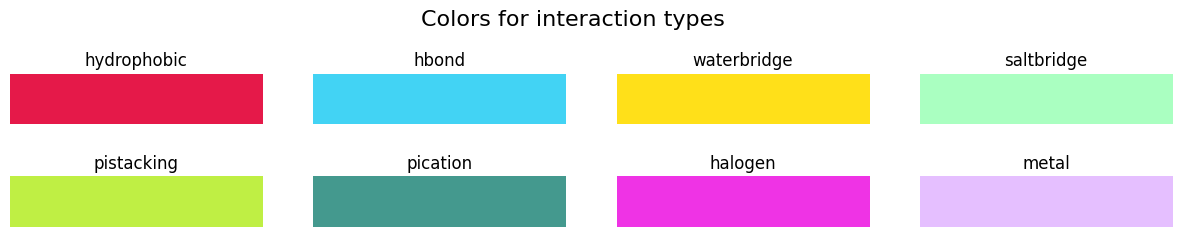

In [290]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 2))
plt.subplots_adjust(hspace=1)
fig.suptitle("Colors for interaction types", size=16, y=1.2)

for ax, (interaction, color) in zip(fig.axes, color_map.items()):
    ax.imshow(np.zeros((1, 5)), cmap=colors.ListedColormap(color_map[interaction]))
    ax.set_title(interaction, loc="center")
    ax.set_axis_off()
plt.show()

In [291]:
import opencadd

# Example usage
print(opencadd.__version__)

0+unknown


In [292]:
from opencadd.structure.core import Structure

In [354]:
def show_interactions_3d(
    pdb_id, selected_site_interactions, highlight_interaction_colors=color_map,
    interaction_data=None, dash_length=0.3, dash_gap=0.2
):
    """
    3D visualization of protein-ligand interactions with permanent labels and dashed bonds.

    Parameters
    ----------
    pdb_id : str
        The pdb ID of interest.
    selected_site_interactions : dict
        Precalculated interactions from PLIP for the selected site
    highlight_interaction_colors : dict
        The colors used to highlight the different interaction types.
    interaction_data : DataFrame
        DataFrame containing detailed interaction information (from create_df_from_binding_site)
    dash_length : float
        Length of each dash in the dashed line (in nanometers)
    dash_gap : float
        Length of gap between dashes (in nanometers)

    Returns
    -------
    NGL viewer with explicit interactions given by PLIP and additional annotations.
    """

    # Create NGLviewer
    viewer = nv.NGLWidget(height="600px", default=True, gui=True)
    # Add protein
    prot_component = viewer.add_pdbid(pdb_id)
    # Add the ligands
    viewer.add_representation(repr_type="ball+stick", selection="hetero and not water")

    interacting_residues = []
    
    for interaction_type, interaction_list in selected_site_interactions.items():
        color = highlight_interaction_colors[interaction_type]
        if len(interaction_list) == 1:
            continue
            
        df_interactions = pd.DataFrame.from_records(
            interaction_list[1:], columns=interaction_list[0]
        )
        
        for _, interaction in df_interactions.iterrows():
            lig_coo = np.array(interaction["LIGCOO"])
            prot_coo = np.array(interaction["PROTCOO"])
            
            # Calculate vector between points and total distance
            vec = prot_coo - lig_coo
            distance = np.linalg.norm(vec)
            unit_vec = vec / distance
            
            # Create dashed line
            num_dashes = int(distance / (dash_length + dash_gap))
            for i in range(num_dashes):
                start = lig_coo + unit_vec * (i * (dash_length + dash_gap))
                end = start + unit_vec * dash_length
                if i == num_dashes - 1:  # Last dash might need to be shorter
                    end = prot_coo
                
                # Add cylinder segment
                viewer.shape.add_cylinder(
                    list(start),
                    list(end),
                    color,
                    [0.1],
                    interaction_type
                )
            
            # Calculate midpoint for label position (slightly offset towards protein)
            midpoint = list(lig_coo + 0.6 * vec)
            
            # Find corresponding interaction in interaction_data if provided
            dist = None
            res_info = ""
            if interaction_data is not None:
                # Find matching interaction
                match = interaction_data[
                    (interaction_data["RESNR"] == interaction["RESNR"]) & 
                    (interaction_data["RESTYPE"] == interaction["RESTYPE"]) &
                    (interaction_data["RESCHAIN"] == interaction["RESCHAIN"])
                ]
                if not match.empty:
                    dist = match.iloc[0]["DIST"]
                    res_info = f"{interaction['RESTYPE']}{interaction['RESNR']}"
            
            # If no interaction_data provided, use calculated distance
            if dist is None:
                dist = distance
                res_info = f"{interaction['RESTYPE']}{interaction['RESNR']}"
            
            # Format the label text
            label_text = f"{res_info}\n{dist:.2f}Å"
            
            # Add permanent label
            viewer.add_label(
                label_text,
                position=midpoint,
                color="black",  # Using black for better visibility
                backgroundColor=color,
                backgroundOpacity=0.7,
                labelType="text",
                fontFamily="sans-serif",
                size=1.2
            )
            
            interacting_residues.append(interaction["RESNR"])
    
    # Display interacting residues
    res_sele = " or ".join([f"({r} and not _H)" for r in interacting_residues])
    res_sele_nc = " or ".join([f"({r} and ((_O) or (_N) or (_S)))" for r in interacting_residues])
    prot_component.add_ball_and_stick(sele=res_sele, colorScheme="chainindex", aspectRatio=1.5)
    prot_component.add_ball_and_stick(sele=res_sele_nc, colorScheme="element", aspectRatio=1.5)
    
    # Center on ligand
    viewer.center("ligand")
    return viewer

In [355]:
viewer_3d = show_interactions_3d(pdb_id, interactions_by_site[selected_site])
viewer_3d
# Get your interaction data


NGLWidget()

In [356]:
viewer_3d.render_image(trim=True, factor=2, transparent=True);

In [357]:
viewer_3d._display_image()